In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgbfir
import ast
from tqdm.autonotebook import tqdm
import shap
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

from ModelProcessing.CategoricalEncoder import Encoder
from ModelProcessing.Filter_fights import Subset
from ModelProcessing.EvaluationPlots import LiftGainChart, BuildROCandPrecisionRecall
from ModelProcessing.GetDifferenceBetweenFighterAttributes import GetTheDifferenceBetweenFighterAttributes
from PreProcessing.Imputer import Imputer
pd.set_option('display.max_columns', 200)
import os
from pathlib import Path

BASE_PATH = Path(os.getcwd())

ufc = pd.read_csv(BASE_PATH/'data/engineered_features.csv')
print(ufc.shape)
ufc.tail()

(5580, 332)


-115.0   
5577              -122.0       -165.750000              -167.5   
5578                 NaN               NaN                 NaN   
5579                 NaN       -171.454545              -170.0   

     red_fighter max red_fighter wins by decision mean  \
5575           242.0                             439.2   
5576          -108.0                             146.4   
5577          -150.0                             171.6   
5578             NaN                               NaN   
5579          -155.0                             301.6   

     red_fighter wins by decision median  red_fighter wins by decision max  \
5575                               450.0                             473.0   
5576                               140.0                             162.0   
5577                               175.0                             188.0   
5578                                 NaN                               NaN   
5579                               300.0                             329.0   

      red_fighter wins by submission mean  \
5575                                940.0   
5576                               1231.0   
5577                                400.0   
5578                                  NaN   
5579                               2200.0   

      red_fighter wins by submission median  \
5575                                  940.0   
5576                                 1231.0   
5577                                  400.0   
5578                                    NaN   
5579                                 2350.0   

      red_fighter wins by submission max  red_fighter wins by tko/ko mean  \
5575                              1100.0                           1012.5   
5576                              1462.0                            842.5   
5577                               400.0                            614.5   
5578                                 NaN                              NaN   
5579                              2500.0                            155.5   

      red_fighter wins by tko/ko median  red_fighter wins by tko/ko max  \
5575                              987.5                          1100.0   
5576                              842.5                          1085.0   
5577                              614.5                           679.0   
5578                                NaN                             NaN   
5579                              155.0                           162.0   

      red_fighter wins in round 1 mean  red_fighter wins in round 1 median  \
5575                             962.5                               962.5   
5576                            1100.0                              1100.0   
5577                             512.5                               500.0   
5578                               NaN                                 NaN   
5579                             462.5                               450.0   

      red_fighter wins in round 1 max  red_fighter wins in round 2 mean  \
5575                           1000.0                            1375.0   
5576                           1350.0                            1437.5   
5577                            550.0                             737.5   
5578                              NaN                               NaN   
5579                            550.0                             637.5   

      red_fighter wins in round 2 median  red_fighter wins in round 2 max  \
5575                              1325.0                           1600.0   
5576                              1437.5                           1675.0   
5577                               725.0                            800.0   
5578                                 NaN                              NaN   
5579                               625.0                            800.0   

      red_fighter wins in round 3 mean  red_fighter wins in round 3 median  \
5575                            2125.0      

In [2]:
x = [np.array(['Holly Holm', 'Irene Aldana', '0', '0', '21 of 50', '12 of 31',
       '42%', '38%', '31 of 60', '13 of 32', '1 of 3', '0 of 0', '33%',
       '---', '0', '0', '0', '0', '0:39', '0:00'], dtype='<U12')
 np.array(['Holly Holm', 'Irene Aldana', '0', '0', '23 of 47', '12 of 32',
       '48%', '37%', '27 of 53', '17 of 37', '1 of 3', '0 of 0', '33%',
       '---', '0', '0', '0', '0', '1:19', '0:00'], dtype='<U12')
 np.array(['Holly Holm', 'Irene Aldana', '0', '0', '23 of 51', '9 of 25',
       '45%', '36%', '37 of 67', '11 of 27', '1 of 2', '0 of 0', '50%',
       '---', '0', '0', '0', '0', '2:06', '0:03'], dtype='<U12')
 np.array(['Holly Holm', 'Irene Aldana', '0', '0', '39 of 58', '18 of 42',
       '67%', '42%', '39 of 60', '19 of 43', '1 of 3', '0 of 0', '33%',
       '---', '0', '0', '0', '0', '0:33', '0:00'], dtype='<U12')
 np.array(['Holly Holm', 'Irene Aldana', '0', '0', '48 of 95', '18 of 55',
       '50%', '32%', '53 of 102', '32 of 71', '1 of 3', '0 of 0', '33%',
       '---', '0', '0', '0', '0', '0:39', '0:00'], dtype='<U12')]

x

SyntaxError: invalid syntax (<ipython-input-2-cb4d5b8381f8>, line 4)

In [62]:
fighters_info_path = BASE_PATH/'data/Tapology_fighter_info_no_nas.csv'
fighter_details_path = BASE_PATH/'data/fighter_details_full.csv'

fighters_info = pd.read_csv(fighters_info_path)
fighters_info.rename(columns = {'Name':'fighter_name'}, inplace = True)

fighter_details = pd.read_csv(fighter_details_path)

print(fighter_details.columns)
print(fighters_info.columns)

Index([&#39;fighter_name&#39;, &#39;Height&#39;, &#39;Weight&#39;, &#39;Reach&#39;, &#39;Stance&#39;, &#39;DOB&#39;], dtype=&#39;object&#39;)
Index([&#39;fighter_name&#39;, &#39;Affiliation&#39;, &#39;Born&#39;, &#39;Fighting out of&#39;], dtype=&#39;object&#39;)


In [63]:
fighter_details = pd.merge(fighter_details, fighters_info, on='fighter_name')

#fighter_details.to_csv(BASE_PATH/'data/complete_fighter_details.csv',index=False)

In [14]:
filename   = BASE_PATH/'data/filtered_fighter_details.csv'
outputfile = BASE_PATH/'data/Tapology_fighter_info.csv'


def check_if_fighters_info_already_collected(outputfile, unique_fighters):

        if os.path.exists(outputfile):
            output = pd.read_csv(outputfile)
            already_collected = output['Name'].values
            print('original size: ' + str(len(unique_fighters)))
            unique_fighters = unique_fighters[~np.isin(unique_fighters, already_collected)]
            print('original size: ' + str(len(unique_fighters)))
            return unique_fighters

        else:
            return unique_fighters


unique_fighters = pd.read_csv(filename).fighter_name.unique()
check_if_fighters_info_already_collected(outputfile, unique_fighters)

original size: 1778
original size: 1767


array([&#39;Christian Aguilera&#39;, &#39;Omari Akhmedov&#39;, &#39;Yoshihiro Akiyama&#39;, ...,
       &#39;Fares Ziam&#39;, &#39;Cat Zingano&#39;, &#39;Allan Zuniga&#39;], dtype=object)

In [9]:
fighters = pd.read_csv(BASE_PATH/'data/fighter_details.csv')
print(fighters.shape)

data = pd.read_csv(BASE_PATH/'data/total_fight_data.csv', parse_dates=['date'])

red_fighters  = data['R_fighter'].tolist()
blue_fighters = data['B_fighter'].tolist()
all_fighters  = red_fighters + blue_fighters

all_unique_fighters = list(set(all_fighters))

filtered_fighters = fighters[fighters['fighter_name'].isin(all_unique_fighters)]
print(filtered_fighters.shape)
filtered_fighters.to_csv(BASE_PATH/'data/filtered_fighter_details.csv',index=False)

(3558, 6)
(1778, 6)


In [124]:
HEADER: str = 'R_fighter;B_fighter;R_KD;B_KD;R_SIG_STR.;B_SIG_STR.\
;R_SIG_STR_pct;B_SIG_STR_pct;R_TOTAL_STR.;B_TOTAL_STR.;R_TD;B_TD;R_TD_pct\
;B_TD_pct;R_SUB_ATT;B_SUB_ATT;R_PASS;B_PASS;R_REV;B_REV;R_HEAD;B_HEAD;R_BODY\
;B_BODY;R_LEG;B_LEG;R_DISTANCE;B_DISTANCE;R_CLINCH;B_CLINCH;R_GROUND;B_GROUND\
;win_by;last_round;last_round_time;Format;Referee;date;location;Fight_type;Winner\
	;R_KD_R1;B_KD_R1;R_SIG_STR._R1;B_SIG_STR._R1;R_SIG_STR_pct_R1;B_SIG_STR_pct_R1\
;R_TOTAL_STR._R1;B_TOTAL_STR._R1;R_TD_R1;B_TD_R1;R_TD_pct_R1;B_TD_pct_R1\
;R_SUB_ATT_R1;B_SUB_ATT_R1;R_PASS_R1;B_PASS_R1;R_REV_R1;B_REV_R1\
	;R_KD_R2;B_KD_R2;R_SIG_STR._R2;B_SIG_STR._R2;R_SIG_STR_pct_R2;B_SIG_STR_pct_R2\
;R_TOTAL_STR._R2;B_TOTAL_STR._R2;R_TD_R2;B_TD_R2;R_TD_pct_R2;B_TD_pct_R2\
;R_SUB_ATT_R2;B_SUB_ATT_R2;R_PASS_R2;B_PASS_R2;R_REV_R2;B_REV_R2\
	;R_KD_R3;B_KD_R3;R_SIG_STR._R3;B_SIG_STR._R3;R_SIG_STR_pct_R3;B_SIG_STR_pct_R3\
;R_TOTAL_STR._R3;B_TOTAL_STR._R3;R_TD_R3;B_TD_R3;R_TD_pct_R3;B_TD_pct_R3\
;R_SUB_ATT_R3;B_SUB_ATT_R3;R_PASS_R3;B_PASS_R3;R_REV_R3;B_REV_R3\
	;R_KD_R4;B_KD_R4;R_SIG_STR._R4;B_SIG_STR._R4;R_SIG_STR_pct_R4;B_SIG_STR_pct_R4\
;R_TOTAL_STR._R4;B_TOTAL_STR._R4;R_TD_R4;B_TD_R4;R_TD_pct_R4;B_TD_pct_R4;R_SUB_ATT_R4\
;B_SUB_ATT_R4;R_PASS_R4;B_PASS_R4;R_REV_R4;B_REV_R4\
	;R_KD_R5;B_KD_R5;R_SIG_STR._R5;B_SIG_STR._R5;R_SIG_STR_pct_R5;B_SIG_STR_pct_R5\
;R_TOTAL_STR._R5;B_TOTAL_STR._R5;R_TD_R5;B_TD_R5;R_TD_pct_R5;B_TD_pct_R5;R_SUB_ATT_R5\
;B_SUB_ATT_R5;R_PASS_R5;B_PASS_R5;R_REV_R5;B_REV_R5\
;R_HEAD_STR_RD_1;B_HEAD_STR_RD_1;R_BODY_STR_RD_1;B_BODY_STR_RD_1;R_LEG_STR_RD_1;B_LEG_STR_RD_1\
;R_DST_STR_RD_1;B_DST_STR_RD_1;R_CLINCH_STR_RD_1;B_CLINCH_STR_RD_1;R_GROUND_STR_RD_1\
;B_GROUND_STR_RD_1\
;R_HEAD_STR_RD_2;B_HEAD_STR_RD_2;R_BODY_STR_RD_2;B_BODY_STR_RD_2;R_LEG_STR_RD_2;B_LEG_STR_RD_2\
;R_DST_STR_RD_2;B_DST_STR_RD_2;R_CLINCH_STR_RD_2;B_CLINCH_STR_RD_2;R_GROUND_STR_RD_2\
;B_GROUND_STR_RD_2\
;R_HEAD_STR_RD_3;B_HEAD_STR_RD_3;R_BODY_STR_RD_3;B_BODY_STR_RD_3;R_LEG_STR_RD_3;B_LEG_STR_RD_3\
;R_DST_STR_RD_3;B_DST_STR_RD_3;R_CLINCH_STR_RD_3;B_CLINCH_STR_RD_3;R_GROUND_STR_RD_3\
;B_GROUND_STR_RD_3\
;R_HEAD_STR_RD_4;B_HEAD_STR_RD_4;R_BODY_STR_RD_4;B_BODY_STR_RD_4;R_LEG_STR_RD_4;B_LEG_STR_RD_4\
;R_DST_STR_RD_4;B_DST_STR_RD_4;R_CLINCH_STR_RD_4;B_CLINCH_STR_RD_4;R_GROUND_STR_RD_4\
;B_GROUND_STR_RD_4\
;R_HEAD_STR_RD_5;B_HEAD_STR_RD_5;R_BODY_STR_RD_5;B_BODY_STR_RD_5;R_LEG_STR_RD_5;B_LEG_STR_RD_5\
;R_DST_STR_RD_5;B_DST_STR_RD_5;R_CLINCH_STR_RD_5;B_CLINCH_STR_RD_5;R_GROUND_STR_RD_5\
;B_GROUND_STR_RD_5\n'



data: str='0;0;13 of 27;1 of 2;48%;50%;53 of 67;6 of 8;4 of 4;0 of 0;100%;0%;1;1;2;0;0;0;0;0;13 of 16;3 of 4;81%;75%;33 of 40;4 of 5;1 of 2;0 of 0;50%;0%;0;0;3;0;1;0;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;12 of 26;0 of 1;1 of 1;0 of 0;0 of 0;1 of 1;0 of 3;1 of 2;0 of 0;0 of 0;13 of 24;0 of 0;12 of 15;1 of 2;1 of 1;2 of 2;0 of 0;0 of 0;1 of 1;0 of 1;1 of 1;0 of 0;11 of 14;3 of 3;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan;nan'

print(len(data.split(';')))
print(len(HEADER.split(';')))

150
191


In [102]:
x = [np.array(['Ricco Rodriguez', 'Pete Williams', '0', '0', '26 of 43', '4 of 6',
       '60%', '66%', '86 of 107', '10 of 13', '5 of 6', '0 of 0', '83%',
       '0%', '1', '1', '5', '0', '1', '0'], dtype='<U15'), np.array(['Ricco Rodriguez', 'Pete Williams', '0', '0', '13 of 27', '1 of 2',     
       '48%', '50%', '53 of 67', '6 of 8', '4 of 4', '0 of 0', '100%',
       '0%', '1', '1', '2', '0', '0', '0'], dtype='<U15'), np.array(['Ricco Rodriguez', 'Pete Williams', '0', '0', '13 of 16', '3 of 4',     
       '81%', '75%', '33 of 40', '4 of 5', '1 of 2', '0 of 0', '50%',
       '0%', '0', '0', '3', '0', '1', '0'], dtype='<U15'), np.array(['Ricco Rodriguez', 'Pete Williams', '26 of 43', '4 of 6', '60%',        
       '66%', '24 of 41', '1 of 3', '2 of 2', '2 of 2', '0 of 0',
       '1 of 1', '1 of 4', '1 of 3', '1 of 1', '0 of 0', '24 of 38',
       '3 of 3'], dtype='<U15'), np.array(['Ricco Rodriguez', 'Pete Williams', '13 of 27', '1 of 2', '48%',
       '50%', '12 of 26', '0 of 1', '1 of 1', '0 of 0', '0 of 0',
       '1 of 1', '0 of 3', '1 of 2', '0 of 0', '0 of 0', '13 of 24',
       '0 of 0'], dtype='<U15'),np.array(['Ricco Rodriguez', 'Pete Williams', '13 of 16', '3 of 4', '81%',
       '75%', '12 of 15', '1 of 2', '1 of 1', '2 of 2', '0 of 0',
       '0 of 0', '1 of 1', '0 of 1', '1 of 1', '0 of 0', '11 of 14',
       '3 of 3'], dtype='<U15')]

print(type(x))

&lt;class &#39;list&#39;&gt;


In [78]:
def split_into_sublists(array:list, condition:str) -> np.array:
    array = np.array(array)
    arrays = np.split(array, np.where(array[:-1] == condition)[0])
    arrays.pop(0)
    return arrays


def pad_data(array:np.array):
    '''
    pad data as not every fight goes the distance so we need to 
    add nans for rounds that did not happen.
    '''
    length = len(array)
    slice_ = int(length/2)
    # 5 rounds is the max so everyone needs that
    pad_number = (10-length)/2

    totals = np.full((5, 20), np.NaN, dtype='object')
    significant_strikes = np.full((5, 18), np.NaN, dtype='object')
    if pad_number > 0:
        
        total = array[:slice_]
        significant_strike = array[slice_:]
        
        totals[:slice_] = total
        significant_strikes[:slice_] = significant_strike

        return np.append(totals, significant_strikes)

    else:
        return array.flatten()


pad_data(x)

6
[array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;26 of 43&#39;, &#39;4 of 6&#39;,
       &#39;60%&#39;, &#39;66%&#39;, &#39;86 of 107&#39;, &#39;10 of 13&#39;, &#39;5 of 6&#39;, &#39;0 of 0&#39;, &#39;83%&#39;,
       &#39;0%&#39;, &#39;1&#39;, &#39;1&#39;, &#39;5&#39;, &#39;0&#39;, &#39;1&#39;, &#39;0&#39;], dtype=&#39;&lt;U15&#39;), array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;13 of 27&#39;, &#39;1 of 2&#39;,
       &#39;48%&#39;, &#39;50%&#39;, &#39;53 of 67&#39;, &#39;6 of 8&#39;, &#39;4 of 4&#39;, &#39;0 of 0&#39;, &#39;100%&#39;,
       &#39;0%&#39;, &#39;1&#39;, &#39;1&#39;, &#39;2&#39;, &#39;0&#39;, &#39;0&#39;, &#39;0&#39;], dtype=&#39;&lt;U15&#39;), array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;13 of 16&#39;, &#39;3 of 4&#39;,
       &#39;81%&#39;, &#39;75%&#39;, &#39;33 of 40&#39;, &#39;4 of 5&#39;, &#39;1 of 2&#39;, &#39;0 of 0&#39;, &#39;50%&

ValueError: could not broadcast input array from shape (20) into shape (5)

In [53]:
x[:3]

[array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;26 of 43&#39;, &#39;4 of 6&#39;,
        &#39;60%&#39;, &#39;66%&#39;, &#39;86 of 107&#39;, &#39;10 of 13&#39;, &#39;5 of 6&#39;, &#39;0 of 0&#39;, &#39;83%&#39;,
        &#39;0%&#39;, &#39;1&#39;, &#39;1&#39;, &#39;5&#39;, &#39;0&#39;, &#39;1&#39;, &#39;0&#39;], dtype=&#39;&lt;U15&#39;),
 array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;13 of 27&#39;, &#39;1 of 2&#39;,
        &#39;48%&#39;, &#39;50%&#39;, &#39;53 of 67&#39;, &#39;6 of 8&#39;, &#39;4 of 4&#39;, &#39;0 of 0&#39;, &#39;100%&#39;,
        &#39;0%&#39;, &#39;1&#39;, &#39;1&#39;, &#39;2&#39;, &#39;0&#39;, &#39;0&#39;, &#39;0&#39;], dtype=&#39;&lt;U15&#39;),
 array([&#39;Ricco Rodriguez&#39;, &#39;Pete Williams&#39;, &#39;0&#39;, &#39;0&#39;, &#39;13 of 16&#39;, &#39;3 of 4&#39;,
        &#39;81%&#39;, &#39;75%&#39;, &#39;33 of 40&#39;, &#39;4 of 5&#39;, &#39;1 of 2&#39;, &#39;0 of 0&#39;, &#39;50%&#39;,
        &#39;0%&#39;, &#39;0&#39;, &#39;0&#39;, &#39;3&#39;, &#39;0&#39;, &#39;1&#39;, &#39;0&#39;], dtype=&#39;&lt;U15&#39;)]

In [3]:
ufc[(ufc.R_fighter == 'Israel Adesanya') | (ufc.B_fighter == 'Israel Adesanya')][['R_fighter','B_fighter']]

R_fighter        B_fighter
4503     Rob Wilkinson  Israel Adesanya
4575   Israel Adesanya   Marvin Vettori
4676      Brad Tavares  Israel Adesanya
4823     Derek Brunson  Israel Adesanya
4964   Israel Adesanya   Anderson Silva
5061   Kelvin Gastelum  Israel Adesanya
5329  Robert Whittaker  Israel Adesanya
5524   Israel Adesanya      Yoel Romero

In [159]:
HEADER: str = 'R_fighter;B_fighter;R_KD;B_KD;R_SIG_STR.;B_SIG_STR.\
;R_SIG_STR_pct;B_SIG_STR_pct;R_TOTAL_STR.;B_TOTAL_STR.;R_TD;B_TD;R_TD_pct\
;B_TD_pct;R_SUB_ATT;B_SUB_ATT;R_PASS;B_PASS;R_REV;B_REV\
;R_HEAD;B_HEAD;R_BODY\
;B_BODY;R_LEG;B_LEG;R_DISTANCE;B_DISTANCE;R_CLINCH;B_CLINCH;R_GROUND;B_GROUND\
;win_by;last_round;last_round_time;Format;Referee;date;location;Fight_type;Winner'


['Israel Adesanya', 'Paulo Costa', '1', '0', '55 of 84', '12 of 26',
'65%', '46%', '55 of 84', '12 of 26', '0 of 0', '0 of 0', '0%',
'0%', '0', '0', '1', '0', '0', '0', 
'59%', '63%', '22 of 37', '7 of 11', '0 of 0', '0 of 0', '0%', '0%', '0', '0', '0', '0', '0', '0', 'KO/TKO', '2', '3:59', '5 Rnd (5-5-5-5-5)', 'Jason Herzog', 'September 26, 2020', 'Abu Dhabi, Abu Dhabi, United Arab Emirates', 'UFC Middleweight Title Bout', 'Israel Adesanya']

len(HEADER.split(';'))

41

In [169]:
len(pickle_load(test_path))

103

In [77]:
import pickle

BASE_PATH = Path(os.getcwd())/'data'
EVENT_AND_FIGHT_LINKS_PATH = BASE_PATH/'event_and_fight_links.pickle'
PAST_EVENT_LINKS_PATH = BASE_PATH/'past_event_links.pickle'
FUTURE_EVENT_LINKS_PATH = BASE_PATH/'future_event_link.pickle'
OLD_PAST_EVENT_LINKS_PATH = BASE_PATH/'old_past_event_links.pickle'
test_path = BASE_PATH/'debug.pickle'
event_urls_path=BASE_PATH/'future_bestfightodds_urls.pickle'

def pickle_load(filename):
	pickle_in = open(filename.as_posix(),"rb")
	past_event_links = pickle.load(pickle_in)
	pickle_in.close()
	return past_event_links


def pickle_file(the_file, filename):

	pickle_out = open(filename.as_posix(),"wb")
	pickle.dump(the_file, pickle_out)
	pickle_out.close()



#data = pickle_load(PAST_EVENT_LINKS_PATH)
#data
past_event_urls = pickle_load(PAST_EVENT_LINKS_PATH)
event_urls = pickle_load(EVENT_AND_FIGHT_LINKS_PATH)
print(past_event_urls.Links.tolist()[0])
event_urls['http://ufcstats.com/event-details/805ad1801eb26abb']
#pickle_file(event_urls[:1], BASE_PATH/'update_odds.pickle')

http://ufcstats.com/event-details/805ad1801eb26abb


[&#39;http://ufcstats.com/fight-details/0005e00b07cee542&#39;,
 &#39;http://ufcstats.com/fight-details/ba6093c9136f99e9&#39;,
 &#39;http://ufcstats.com/fight-details/81b16b26774be5d1&#39;,
 &#39;http://ufcstats.com/fight-details/c00a8682fb5b71bd&#39;,
 &#39;http://ufcstats.com/fight-details/1e7caef3f6dfde10&#39;,
 &#39;http://ufcstats.com/fight-details/24ff0bb908095565&#39;,
 &#39;http://ufcstats.com/fight-details/f4e262b04f4e94bd&#39;,
 &#39;http://ufcstats.com/fight-details/15a422574c3b89e1&#39;,
 &#39;http://ufcstats.com/fight-details/87105c63df95f929&#39;,
 &#39;http://ufcstats.com/fight-details/ac6b2a5f24c2b8bd&#39;,
 &#39;http://ufcstats.com/fight-details/d866afa89d62a4ae&#39;]

In [171]:
past = data[10:]
pickle_file(past, PAST_EVENT_LINKS_PATH)

In [6]:
def get_the_difference_between_dfs(df1, df2, on='Events'):
    '''
    gets the difference betweeen rows it is not symetric so the most recent or larger df
    should be df1
    '''
    difference = df1.merge(df2, how = 'outer' , on=on, indicator=True)
    difference = difference.loc[difference['_merge'] == 'left_only']

    difference.rename(columns={"Links_x": "Links",
                               "Date_x":'Date'}, inplace=True)
    del difference['Links_y']
    del difference['_merge']
    del difference['Date_y']

    return difference

#past = future[17:]
#pickle_file(past, PAST_EVENT_LINKS_PATH)
pickle_load(PAST_EVENT_LINKS_PATH)

Events  \
1               UFC 253: Adesanya vs. Costa   
2    UFC Fight Night: Covington vs. Woodley   
3        UFC Fight Night: Waterson vs. Hill   
4        UFC Fight Night: Overeem vs. Sakai   
5          UFC Fight Night: Smith vs. Rakic   
..                                      ...   
530          UFC 5: The Return of the Beast   
531          UFC 4: Revenge of the Warriors   
532               UFC 3: The American Dream   
533                       UFC 2: No Way Out   
534                    UFC 1: The Beginning   

                                                 Links                Date  
1    http://ufcstats.com/event-details/e69c5ce12f4e...  September 26, 2020  
2    http://ufcstats.com/event-details/831b93781180...  September 19, 2020  
3    http://ufcstats.com/event-details/9c37681096c6...  September 12, 2020  
4    http://ufcstats.com/event-details/542db012217e...  September 05, 2020  
5    http://ufcstats.com/event-details/e29cf523ebd1...     August 29, 2020  
..                                                 ...                 ...  
530  http://ufcstats.com/event-details/dedc3bb440d0...      April 07, 1995  
531  http://ufcstats.com/event-details/b60391da771d...   December 16, 1994  
532  http://ufcstats.com/event-details/1a49e0670dfa...  September 09, 1994  
533  http://ufcstats.com/event-details/a6a9ab5a824e...      March 11, 1994  
534  http://ufcstats.com/event-details/6420efac0578...   November 12, 1993  

[534 rows x 3 columns]

In [28]:
# Subset Data
my_filter = Subset(ufc)
my_filter.subset_on_number_of_fights(number_of_fights=3)
my_filter.subset_on_draws
filtered_ufc = my_filter.df

# Encode Data
ufc_encoder = Encoder(filtered_ufc)
ufc_encoder.encode_weight_class
ufc_encoder.encode_title_bout
ufc_encoder.encode_winner
ufc_encoder.Difference_in_stances
encoded_ufc = ufc_encoder.df

# Impute missing values
imputer = Imputer(encoded_ufc)
cleaned_ufc = imputer.impute('bfill')
cleaned_ufc = imputer.impute_missing_values()

0%|          | 0/690 [00:00<?, ?it/s]Original Shape with all fights: (4310, 332)
New Shape with fighters over 3 fights (1607, 332)
Original Shape including Draws: (1607, 332)
New Shape with excluding draws(1579, 332)
100%|██████████| 690/690 [07:10<00:00,  1.60it/s]
These Columns have Missing Values['B_Takedown_Defense', 'B_distance_beaten', 'B_odds_varience', 'B_average_fighter_odds', 'B_average_opponent_odds', 'R_distance_beaten', 'R_odds_varience', 'R_average_fighter_odds', 'R_average_opponent_odds', 'blue_fighter mean', 'blue_fighter median', 'blue_fighter max', 'blue_fighter wins by decision mean', 'blue_fighter wins by decision median', 'blue_fighter wins by decision max', 'blue_fighter wins by submission mean', 'blue_fighter wins by submission median', 'blue_fighter wins by submission max', 'blue_fighter wins by tko/ko mean', 'blue_fighter wins by tko/ko median', 'blue_fighter wins by tko/ko max', 'blue_fighter wins in round 1 mean', 'blue_fighter wins in round 1 median', 'blue_

In [50]:
cleaned_ufc[['B_Strikes_Per_Minute', 'B_Striking Accuracy', 'B_Strikes_Absorbed_per_Minute',
'B_Striking Defense', 'B_Average_Num_Takedowns', 'B_Submission Attempts', 'B_Takedown Accuracy','B_Takedown_Defense']]


well_rounded = []

B_Strikes_Per_Minute  B_Striking Accuracy  \
170               0.527497             1.443978   
171               0.345885             3.044444   
189               0.382023             2.409799   
198               1.748453             0.366334   
219               0.529151             4.265700   
...                    ...                  ...   
4306              4.652404             0.464966   
4308              6.916503             0.461628   
4300              3.672056             0.407340   
4305              0.501894             3.556826   
4309             10.441600             0.370594   

      B_Strikes_Absorbed_per_Minute  B_Striking Defense  \
170                        0.765123            2.083333   
171                        0.569781            0.000000   
189                        0.462745            0.000000   
198                        1.802131            0.562481   
219                        0.465468            0.102738   
...                             ...                 ...   
4306                       1.969540            0.585080   
4308                       5.250654            0.631172   
4300                       2.256894            0.793759   
4305                       0.516873            0.109468   
4309                       6.700818            0.653076   

      B_Average_Num_Takedowns  B_Submission Attempts  B_Takedown Accuracy  \
170                 26.342101               1.165501            25.903458   
171                 26.218523               0.333333             8.222222   
189                 33.790813               0.000000             8.222617   
198                  4.427702               3.616438             0.425926   
219                 23.977253               0.666667             4.154911   
...                       ...                    ...                  ...   
4306                 1.188088               0.188088             0.405952   
4308                 0.509221               0.153846             0.708333   
4300                 2.553603               1.476378             0.516667   
4305                34.053837               0.922411             5.688080   
4309                 0.408773               0.090909             0.761905   

      B_Takedown_Defense  
170             0.125000  
171             0.733333  
189             0.485065  
198             0.388889  
219             1.000000  
...                  ...  
4306            0.821577  
4308            0.541667  
4300            0.750000  
4305            0.535714  
4309            0.735000  

[1579 rows x 8 columns]

Text(0.5, 1.0, 'UMAP projection of the UFC dataset')

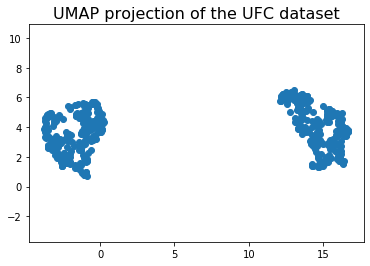

In [48]:
import umap
from sklearn.preprocessing import StandardScaler


ufc_data = cleaned_ufc.sort_values('date').drop_duplicates(['R_fighter'], keep='last')
ufc_data = ufc_data[['B_Strikes_Per_Minute', 'B_Striking Accuracy', 'B_Strikes_Absorbed_per_Minute',
'B_Striking Defense', 'B_Average_Num_Takedowns', 'B_Submission Attempts', 'B_Takedown Accuracy','B_Takedown_Defense']].values



['R_Strikes_Per_Minute', 'R_Striking Accuracy', 'R_Strikes_Absorbed_per_Minute',
'R_Striking Defense', 'R_Average_Num_Takedowns', 'R_Submission Attempts', 'R_Takedown Accuracy'	'R_Takedown_Defense']

['R_Log_Striking_Defense',
'R_Takedown_Defense',
'R_Strikes_Absorbed_per_Minute',
'R_Average_Num_Takedowns']



reducer = umap.UMAP()

scaled_ufc_data = StandardScaler().fit_transform(ufc_data)
embedding = reducer.fit_transform(scaled_ufc_data)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the UFC dataset', fontsize=16)

In [5]:
def flip_data(df):

    df = df.copy()
    raw_df = df.copy()

    df['fight_id'] = np.arange(0, df.shape[0])
    raw_df['fight_id'] = np.arange(0, raw_df.shape[0])

    df.columns = df.columns.map(flip_color_of_colums)
    df = flip_winner(df)

    difference = GetTheDifferenceBetweenFighterAttributes(df)
    difference.get_difference_between_fighters_stats(cols_to_keep_whole=['Average_Odds_f1',
                                                                     'Average_Odds_f2',
                                                                     'title_bout',
                                                                     'title_bout_encoded',
                                                                     'Winner_encoded',
                                                                     'fight_weight'])
    df = difference.get_data()


    difference = GetTheDifferenceBetweenFighterAttributes(raw_df)
    difference.get_difference_between_fighters_stats(cols_to_keep_whole=['Average_Odds_f1',
                                                                     'Average_Odds_f2',
                                                                     'title_bout',
                                                                     'title_bout_encoded',
                                                                     'Winner_encoded',
                                                                     'fight_weight'])
    raw_df = difference.get_data()


    subset = ['R_elo_expected', 'difference_Log_Striking_Defense', 'Winner_encoded', 'B_avg_opp_TD_pct',                    'difference_RingRust', 'red_fighter median', 'blue_fighter median', 'R_avg_opp_HEAD_landed',  'difference_age', 'B_distance_lost', 'R_distance_beaten', 'R_avg_GROUND_landed', 'difference_longest_win_streak', 'difference_avg_HEAD_landed', 'date', 'fight_weight','wrestling_blue_skill', 'striking_difference_skill', 'difference_fighter mean', 'R_avg_GROUND_att', 'blue_stamina','red_stamina','difference_avg_opp_CLINCH_landed', 'under 2½ rounds mean', 'blue_fighter wins by decision mean', 'red_fighter wins in round 1 mean',
'g_and_p_red_skill','difference_win_by_Decision_Unanimous', 'fight_id', 'R_fighter']


    return concatenate_dfs(df, raw_df)[subset]


def flip_color_of_colums(col):
    return \
            f'R_{col[2:]}' if col.startswith('B_') else \
            f'B_{col[2:]}' if col.startswith('R_') else \
            col.replace('blue','red') if 'blue' in col else \
            col.replace('red','blue') if 'red' in col else \
            col


def flip_winner(df):
    df['Winner_encoded'] = 1 - df['Winner_encoded']
    return df


def concatenate_dfs(df_one, df_two):

    if set(df_one.columns.to_list()) == set(df_two.columns.to_list()):
        df = pd.concat([df_one, df_two], ignore_index=True, sort=True)

    else:
        raise AttributeError('Dfs do not have the same column names')

    return df


def filter_data_by_index(df, date_range):
    
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    train = df[(df.date >= date_range[0]) & (df.date < date_range[1])]
    test = df[(df.date >= date_range[1])]

    return train, test


filterd_mixed_effects = flip_data(cleaned_ufc)
training , testing = filter_data_by_index(filterd_mixed_effects, ('2012-01-01', '2020-03-01'))
training.to_csv('mixed_effects_training.csv', index=False)
testing.to_csv('mixed_effects_testing.csv', index=False)
testing

R_elo_expected  difference_Log_Striking_Defense  Winner_encoded  \
1548        0.276194                         0.130509               0   
1549        0.202703                        -0.024903               0   
1550        0.378584                         0.181677               0   
1551        0.498670                        -0.004542               0   
1552        0.541853                         0.388586               0   
...              ...                              ...             ...   
3153        0.477730                        -0.197913               0   
3154        0.585675                         0.003363               1   
3155        0.637124                        -0.407252               1   
3156        0.530314                         0.263357               1   
3157        0.636867                        -0.185902               1   

      B_avg_opp_TD_pct  difference_RingRust  red_fighter median  \
1548          0.346500            16.578468            0.635176   
1549          0.102857            88.693942            0.290807   
1550          0.000000            -2.993185            0.653846   
1551          0.149375           -12.571668            0.384918   
1552          0.346875            72.235100            0.448239   
...                ...                  ...                 ...   
3153          0.117500           -31.262787            0.416476   
3154          0.402857           -23.633924            0.674608   
3155          0.266000            -6.556693            0.589158   
3156          0.250000             1.080584            0.642464   
3157          0.140000           -48.241062            0.426026   

      blue_fighter median  R_avg_opp_HEAD_landed  difference_age  \
1548             0.364824              28.250000            -1.0   
1549             0.709193              22.666667            12.0   
1550             0.346154              34.076923             2.0   
1551             0.615082              24.500000             1.0   
1552             0.551761              34.250000             2.0   
...                   ...                    ...             ...   
3153             0.583524              27.222222             3.0   
3154             0.325392              40.100000            -4.0   
3155             0.410842              34.600000             0.0   
3156             0.357536              18.800000            -5.0   
3157             0.573974              16.000000             3.0   

      B_distance_lost  R_distance_beaten  R_avg_GROUND_landed  \
1548         1.369202           1.874901             5.583333   
1549      9999.000000           2.194224             8.333333   
1550      9999.000000           2.355921             1.230769   
1551         2.109531           1.927029             5.833333   
1552         1.876819           4.440507             4.125000   
...               ...                ...                  ...   
3153         2.581885           3.359158             6.111111   
3154         1.947386           2.024961             5.400000   
3155         2.124983           2.455064             7.500000   
3156         2.373328           1.701687             5.600000   
3157         3.117838           2.392130             8.764706   

      difference_longest_win_streak  difference_avg_HEAD_landed       date  \
1548                           -3.0                    1.333333 2020-03-07   
1549                            1.0                   -5.226190 2020-03-07   
1550                            4.0                   25.461538 2020-03-07   
1551                           -2.0                    8.041667 2020-03-07   
1552                           -2.0                   18.687500 2020-03-07   
...                             ...                         ...        ...   
3153                           -3.0                    6.388889 2020-05-16   
3154                           -1.0                   -6.571429 2020-05-16   
3155                    

In [55]:
def drop_cols(df):
    df = df.copy()
    df.drop(['R_fighter', 'B_fighter', 
                  'win_by','Winner','B_Beaten_Names', 'B_Lost_to_names', 'R_Beaten_Names', 'R_Lost_to_names',
                  'B_Stats_of_Opponents_they_have_beaten',  'B_Stats_of_Opponents_they_have_lost_to',
                  'R_Stats_of_Opponents_they_have_beaten',  'R_Stats_of_Opponents_they_have_lost_to',],  axis=1, inplace=True)

    numeric_cols = df.select_dtypes([np.int, np.int64 , np.float, np.bool]).dtypes.index
    print('The following columns have been removed: '+ str(set(df.columns).symmetric_difference(numeric_cols)))
    
    new_df = df[numeric_cols]
    new_df['date'] = df['date']
    
    return new_df

ufc_cleaned = drop_cols(cleaned_ufc)

The following columns have been removed: {'date'}


In [56]:
def normalize_all_columns_with_respect_to_weight_class(df):
    
    df = df.copy()

    print(df.shape)
    cols = [i for i in ufc_cleaned._get_numeric_data().columns if i not in ['Average_Odds_f1',
                                                                            'Average_Odds_f2',
                                                                            'title_bout',
                                                                            'title_bout_encoded',
                                                                            'Winner_encoded',
                                                                            'fight_weight',
                                                                            'red_fighter_odds',
                                                                            'blue_fighter_odds']]

    cols_without_weight = [i for i in ufc_cleaned._get_numeric_data().columns if i not in ['Average_Odds_f1',
                                                                            'Average_Odds_f2',
                                                                            'title_bout',
                                                                            'title_bout_encoded',
                                                                            'Winner_encoded',
                                                                            'fight_weight',
                                                                            'weight_class',
                                                                            'red_fighter_odds',
                                                                            'blue_fighter_odds']]

    df[cols_without_weight] = df[cols].groupby('weight_class').transform(lambda x: (x - x.mean()) / x.std())
    print(df.shape)
    return df

    

difference = GetTheDifferenceBetweenFighterAttributes(ufc_cleaned)
difference.get_difference_between_fighters_stats(cols_to_keep_whole=['Average_Odds_f1',
                                                                     'Average_Odds_f2',
                                                                     'title_bout',
                                                                     'title_bout_encoded',
                                                                     'Winner_encoded',
                                                                     'fight_weight'],
                                                subtract_or_divide= 'ratio')
ufc_cleaned = difference.get_data()
ufc_cleaned.drop(['blue_Fighter_Odds','red_Fighter_Odds','difference_Fighter_Odds'], axis=1, inplace=True)

Training range: (2012-01-14 00:00:00, 2019-11-16 00:00:00)    (Test range: 2019-12-07 00:00:00, 2019-12-07 00:00:00)
Training range: (2012-01-14 00:00:00, 2019-12-07 00:00:00)    (Test range: 2019-12-14 00:00:00, 2019-12-14 00:00:00)
Training range: (2012-01-14 00:00:00, 2019-12-14 00:00:00)    (Test range: 2019-12-21 00:00:00, 2019-12-21 00:00:00)
Training range: (2012-01-14 00:00:00, 2019-12-21 00:00:00)    (Test range: 2020-01-18 00:00:00, 2020-01-18 00:00:00)
Training range: (2012-01-14 00:00:00, 2020-01-18 00:00:00)    (Test range: 2020-01-25 00:00:00, 2020-01-25 00:00:00)
Training range: (2012-01-14 00:00:00, 2020-01-25 00:00:00)    (Test range: 2020-02-08 00:00:00, 2020-02-08 00:00:00)
Training range: (2012-01-14 00:00:00, 2020-02-08 00:00:00)    (Test range: 2020-02-15 00:00:00, 2020-02-15 00:00:00)
Training range: (2012-01-14 00:00:00, 2020-02-15 00:00:00)    (Test range: 2020-02-22 00:00:00, 2020-02-22 00:00:00)
Training range: (2012-01-14 00:00:00, 2020-02-22 00:00:00)    (T

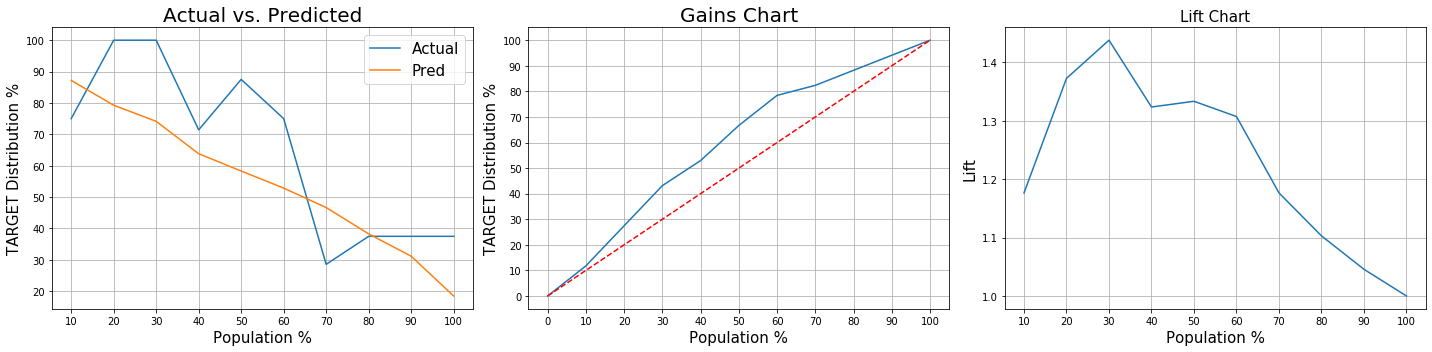

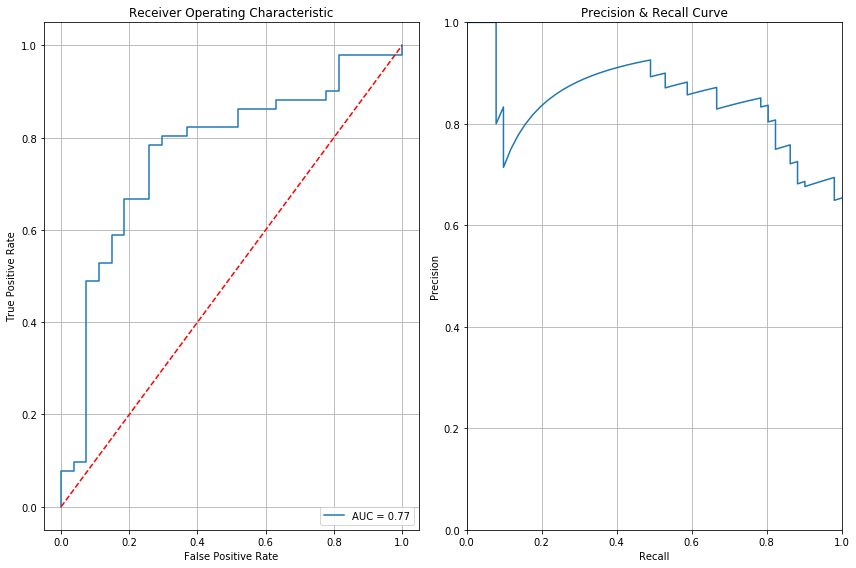

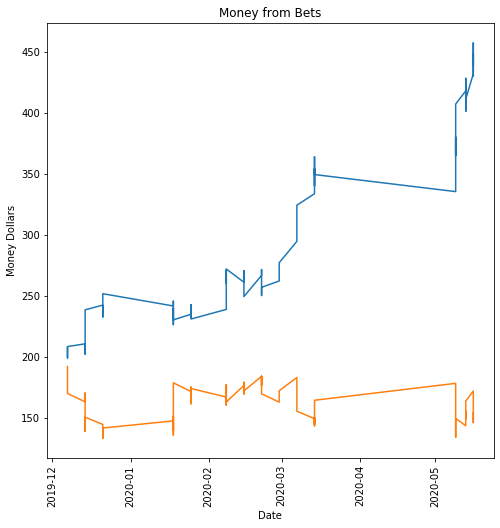

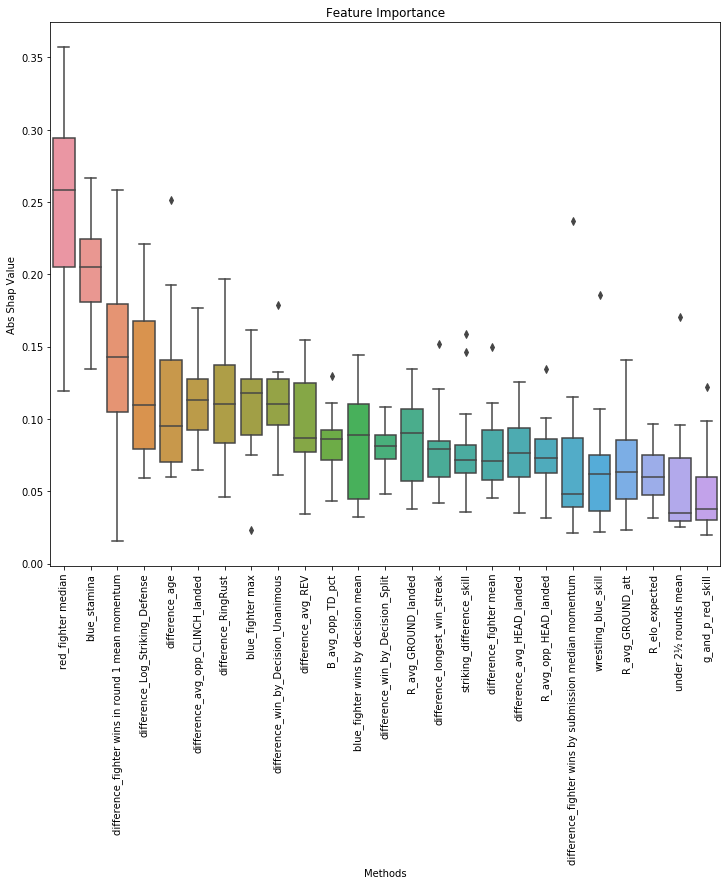

In [57]:
class Bookies:


    def __init__(self, initial_pot):
        self.pot = initial_pot



    def Place_bet(self, stake, red_fighter_odds, blue_fighter_odds, prediction, winner):

        stake = self.pot*0.04

        if prediction == winner:

            if prediction == 1:
                winnings = self.Calculate_Winnings(stake, red_fighter_odds)
                payout   = winnings
                self.pot = self.pot + payout

            else:
                winnings = self.Calculate_Winnings(stake, blue_fighter_odds)
                payout   = winnings
                self.pot = self.pot + payout
        

        else:
            self.pot = self.pot - stake


        return self.pot



    @staticmethod
    def Calculate_Winnings(stake, odds):

        if odds > 0:
            winnings = (stake*odds)/100

        else:
            winnings = (stake/odds) * 100

        return abs(winnings)


class BackTest:
    

    def __init__(self, df, model, date_range, y, sample_weights = False):

        self.model = model
        self.date_range = date_range
        self.sample_weights = sample_weights
        self.df = df.copy()
        self.df = self.create_datetime_index(self.df, 'date')
        self.most_recent_date = self.df.index.max()
        self.dates = self.df.index.unique().to_list()
        self.y = y


    @staticmethod
    def create_datetime_index(df, date_col):

        if not date_col in df.columns:
            raise AttributeError('The column ' + str(date_col) + ' does not exist!')

        datetime_series = pd.to_datetime(df[date_col])
        datetime_index = pd.DatetimeIndex(datetime_series.values)
        df.set_index(datetime_index, inplace=True)
        df.drop(date_col, axis=1, inplace=True)
        return df


    @staticmethod
    def check_if_tuple(obj):

        if isinstance(obj, tuple):
            return True
        else:
            return False

    
    def initlize_index(self):

        df = self.df.copy()
        if self.check_if_tuple(self.date_range):

            filtered_df = df[self.date_range[0]:self.date_range[1]]
            index = self.dates.index(max(filtered_df.index))

            return index

        else:

            filtered_df = df[:self.date_range]
            index = self.dates.index(max(filtered_df.index))

            return index


    def filter_data_by_index(self, df, date_range):

        df = df.copy()
        if self.check_if_tuple(date_range):

            X_train = df[date_range[0]:date_range[1]]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')

            return X_train, X_test, y_train, y_test, index, weights

        else:

            X_train = df[:date_range]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')


            return X_train, X_test, y_train, y_test, index, weights


    def update_date_range(self, date_range, index):

        if self.check_if_tuple(date_range):
            new_date   = self.dates[index+1]
            new_date_range = (date_range[0], new_date)
            return new_date_range

        else:
            new_date   = self.dates[index+1]
            new_date_range = new_date
            return new_date_range


    @staticmethod
    def place_bets(row, bookie, stake, favourite=False):

        if favourite:

            return bookie.Place_bet(stake=stake, red_fighter_odds=row['Red Odds'],
                    blue_fighter_odds=row['Blue Odds'], prediction=row['Favourite'], winner=row['Actual'])
        
        else:

            return bookie.Place_bet(stake=stake, red_fighter_odds=row['Red Odds'],
                    blue_fighter_odds=row['Blue Odds'], prediction=row['Predicted'], winner=row['Actual'])


    @staticmethod
    def get_shap_values(model, values):

        explainer   = shap.TreeExplainer(model, feature_perturbation = "tree_path_dependent")
        shap_values = np.array(explainer.shap_values(values))

        if len(shap_values.shape) == 3:
            shap_values = np.abs(shap_values).sum(axis=0)
            shap_values = shap_values.mean(0)
        
        else:
            shap_values = np.abs(shap_values).mean(0)

        return shap_values

    @staticmethod
    def plot(data):

        plt.figure(figsize=(12, 10))
        data['index'] = data.index
        data = pd.melt(data, id_vars='index', var_name='Methods')
        order = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).indexorder = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).index

        data = data[data["Methods"].isin(order[:25])]
        ax = sns.boxplot(x=data["Methods"], y=data["value"],
                                order=order)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=10)
        ax.set_title('Feature Importance')
        ax.set_ylabel('Abs Shap Value')
        plt.plot()


    @staticmethod
    def get_interactions(model, feature_names, output_file):
        xgbfir.saveXgbFI(model, feature_names=feature_names, OutputXlsxFile= output_file + '.xlsx')
 


    def fit(self):

        index = self.initlize_index()
        probas = []
        y_true = []
        red_fighter_odds  = []
        blue_fighter_odds = []
        date = []
        
        count = 0
        importances = []
        while self.dates[index+1] != self.most_recent_date:
            
            X_train, X_test, y_train, y_test, index, weights = self.filter_data_by_index(self.df, self.date_range)

            X_train.pop('Average_Odds_f1')
            X_train.pop('Average_Odds_f2')

            date.append(X_test.index.values)
            red_fighter_odds.append(X_test.pop('Average_Odds_f1'))
            blue_fighter_odds.append(X_test.pop('Average_Odds_f2'))


            if self.sample_weights == True:
                probabilities = self.model.fit(X_train, y_train, sample_weight=weights).predict_proba(X_test)[:,1]

            else:
                probabilities = self.model.fit(X_train, y_train).predict_proba(X_test)[:,1]


            #if (count == 6) | (count == 6):
            #    self.get_interactions(self.model, X_train.columns.to_list(), 'interactions'+str(count))


            probas.append(probabilities)
            y_true.append(y_test.values)

            importances.append(self.get_shap_values(self.model, X_test))

            self.date_range = self.update_date_range(self.date_range, index)
            
            print('Training range: (' + str(X_train.index.min()) +  ', ' + str(X_train.index.max()) +')' + '    (Test range: ' \
                   + str(X_test.index.min()) + ', ' + str(X_test.index.max()) +')' )

            count +=1


        date = np.concatenate(date).ravel()
        y_true = np.concatenate(y_true).ravel()
        probas = np.concatenate(probas).ravel()
        red_fighter_odds  = np.concatenate(red_fighter_odds).ravel()
        blue_fighter_odds = np.concatenate(blue_fighter_odds).ravel()

        preds = np.where(probas > 0.4, 1, 0)
        print(f'{classification_report(y_true, preds)}')

        LiftGainChart(y_true=y_true, probas=probas)
        BuildROCandPrecisionRecall(y_true=y_true, probas=probas)


        data = pd.DataFrame({
                      'Date':date,
                      'Actual':y_true,
                      'Predicted':preds,
                      'Probas':probas,
                      'Red Odds': red_fighter_odds,
                      'Blue Odds': blue_fighter_odds})

        data['Favourite'] = np.where(data['Red Odds'] > data['Blue Odds'], 1, 0)

        bookie = Bookies(initial_pot=200)
        data['My_Money_Model'] = data.apply(lambda x: self.place_bets(x, bookie, 10, favourite=False), axis=1)

        bookie2 = Bookies(initial_pot=200)
        data['My_Money_Fav'] = data.apply(lambda x: self.place_bets(x, bookie2, 10, favourite=True), axis=1)

        plt.figure(figsize=(8, 8))
        plt.title('Money from Bets')
        plt.ylabel('Money Dollars')
        plt.xlabel('Date')
        plt.plot(data['Date'], data['My_Money_Model'])
        plt.plot(data['Date'], data['My_Money_Fav'])
        plt.xticks(rotation='vertical')
        plt.show()


        importance_data = np.stack(importances, axis=0)
        importance_data = pd.DataFrame(importance_data, columns=X_test.columns.to_list())

        self.plot(importance_data)
        


subset = ['R_elo_expected', 'difference_Log_Striking_Defense', 'Winner_encoded', 'Average_Odds_f1', 'B_avg_opp_TD_pct', 'difference_RingRust', 'red_fighter median', 'blue_fighter median', 'R_avg_opp_HEAD_landed',  'difference_age',   'Average_Odds_f2', 'B_distance_lost', 'R_distance_beaten', 'R_avg_GROUND_landed', 'difference_longest_win_streak', 'difference_avg_HEAD_landed', 'date', 'fight_weight','wrestling_blue_skill', 'striking_difference_skill', 'difference_fighter mean', 'R_avg_GROUND_att', 'blue_stamina','red_stamina','difference_avg_opp_CLINCH_landed', 'under 2½ rounds mean', 'blue_fighter wins by decision mean', 'red_fighter wins in round 1 mean', 'difference_avg_REV', 'difference_fighter wins in round 1 mean momentum',
'g_and_p_red_skill','difference_win_by_Decision_Unanimous', 'difference_win_by_Decision_Split', 'blue_fighter max', 'difference_fighter wins by submission median momentum',
'difference_fighter wins by submission mean momentum']


# interactions
#ufc_cleaned['interaction_1'] = ufc_cleaned['R_distance_beaten']*ufc_cleaned['difference_fighter mean']
#ufc_cleaned['interaction_2'] = ufc_cleaned['red_fighter median'] - ufc_cleaned['blue_fighter median']

#ufc_cleaned['interaction_3'] = ufc_cleaned['blue_fighter mean']*ufc_cleaned['blue_fighter mean']*ufc_cleaned['blue_fighter wins by tko/ko mean']
#ufc_cleaned['interaction_4'] = ufc_cleaned['B_Strikes_Per_Minute']*ufc_cleaned['wrestling_red_skill']
#ufc_cleaned['interaction_5'] = ufc_cleaned['blue_fighter median']*ufc_cleaned['blue_fighter mean']
#ufc_cleaned['interaction_6'] = ufc_cleaned['blue_fighter median']*ufc_cleaned['R_avg_opp_SIG_STR_landed']

model_forest = RandomForestClassifier(max_depth=6,
                                  random_state = 43,
                                  n_estimators=300,
                                  bootstrap=True,
                                  min_samples_leaf=6,
                                  min_samples_split=7,
                                  class_weight='balanced')

model_xgb = XGBClassifier(objective= 'binary:logistic',
                        nthread=4,
                        seed=42,
                        max_depth=5,
                        min_child_weight=2,
                        n_estimators=50,
                        colsample_bytree=0.9,
                        gamma=0.3,
                        learning_rate=0.1,
                        subsample=0.9,
                        reg_alpha=1e-05 )



ufc_cleaned_ = ufc_cleaned[subset]

six_months_ago = date.today() + relativedelta(months=-9)
backtest = BackTest(ufc_cleaned_, model_xgb, date_range=('2012-01-01',six_months_ago), y='Winner_encoded', sample_weights=False)
data = backtest.fit()

In [ ]:
ufc_ = ufc_cleaned[subset]

ufc_['R_fighter'] = r_fighter
ufc_['B_fighter'] = b_fighter

In [191]:
def check(clf, X, y):

    print(f'{classification_report(y, clf.predict(X))}')
    shap.initjs()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    return shap.summary_plot(shap_values[1], X, plot_type='dot')


def cross_validate_catboost(X, y, **kwargs):
    import catboost, utils
    models = cross_validate(
             catboost.CatBoostClassifier(od_type='Iter',
                                         od_wait=10,
                                         eval_metric='AUC', 
                                         **kwargs
                                         ),
                             X, y,
                             fit=lambda m,Xt,yt,Xv,yv: m.fit(Xt, yt, eval_set=(Xv,yv),
                             cat_features=np.where(X.dtypes == 'category')[0],
                             verbose=0))
                             
    return pd.DataFrame(models)


def balancing_params(y):
    counts = y.value_counts()
    return { 'class_names': list(counts.index), 'class_weights': len(y) / counts.values }


subset = ['R_elo_expected', 'difference_Log_Striking_Defense', 'Winner_encoded', 'Average_Odds_f1', 'R_avg_opp_SIG_STR_pct_diff_odds', 'B_avg_opp_TD_pct', 'difference_RingRust', 'interaction_blue_odds_difference_log_striking_ratio', 'red_Fighter_Odds', 'difference_Fighter_Odds', 'R_avg_opp_HEAD_landed', 'interaction_B_distance_lost_blue_odds_difference_log_striking_defense', 'R_avg_opp_SIG_STR_landed', 'interaction_B_odds_B_lost', 'difference_opp_log_striking_ratio', 'difference_age', 'blue_Fighter_Odds', 'R_avg_GROUND_att', 'interaction_blue_odds_difference_log_striking_defense', 'interaction_B_odds_R_rounds', 'Average_Odds_f2', 'B_distance_lost', 'R_distance_beaten', 'R_avg_GROUND_landed', 'difference_avg_HEAD_landed', 'date', 'fight_weight','wrestling_blue_skill',
'grappling_difference_skill', 'R_distance_beat_blue_Fighter_Odds', 'difference_fighter_odds_2','difference_avg_opp_CLINCH_landed',
'difference_longest_win_streak']


X = ufc_cleaned.copy()
X = X[subset]
X.pop('date')
X.pop('Average_Odds_f2')
X.pop('Average_Odds_f1')
y = X.pop('Winner_encoded')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
model_forest = RandomForestClassifier(criterion='gini', max_depth=4, class_weight='balanced')
model_forest.fit(X_train, y_train)

KeyError: "['R_avg_opp_SIG_STR_pct_diff_odds', 'blue_Fighter_Odds', 'difference_fighter_odds_2', 'interaction_B_distance_lost_blue_odds_difference_log_striking_defense', 'interaction_blue_odds_difference_log_striking_defense', 'interaction_blue_odds_difference_log_striking_ratio', 'red_Fighter_Odds', 'difference_Fighter_Odds', 'interaction_B_odds_R_rounds', 'interaction_B_odds_B_lost', 'R_distance_beat_blue_Fighter_Odds'] not in index"

In [94]:
from sklearn.model_selection import GridSearchCV
from collections import Counter

estimator = XGBClassifier(

    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    max_depth=3,
    min_child_weight=2,
    n_estimators=50,
    colsample_bytree=0.9,
    gamma=0.3,
    learning_rate=0.1,
    subsample=0.9,
    reg_alpha=1e-05

)


counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

parameters = {

     #'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
     'scale_pos_weight':[1,estimate]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)

NameError: name 'y' is not defined

In [36]:
grid_search.best_params_,

({'scale_pos_weight': 1},)

In [27]:
estimator = RandomForestClassifier(max_depth=6,
                                  n_estimators=300,
                                  bootstrap=True,
                                  min_samples_leaf=6,
                                  min_samples_split=7,
                                  class_weight=balanced)



parameters = {

    #'max_depth':range(1,8,1),
    #'n_estimators': range(50,350, 50)
    #'min_samples_split': range(1,10,1),
    #'min_samples_leaf': range(1,10,1),
    #'bootstrap': [True, False]
    'class_weight':['balanced',None]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    4.1s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=6,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=6,
                                              min_samples_split=7,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False,
                                              random_

In [28]:
grid_search.best_params_

{'class_weight': 'balanced'}

precision    recall  f1-score   support

           0       0.60      0.80      0.68       503
           1       0.83      0.64      0.73       760

    accuracy                           0.71      1263
   macro avg       0.71      0.72      0.70      1263
weighted avg       0.74      0.71      0.71      1263



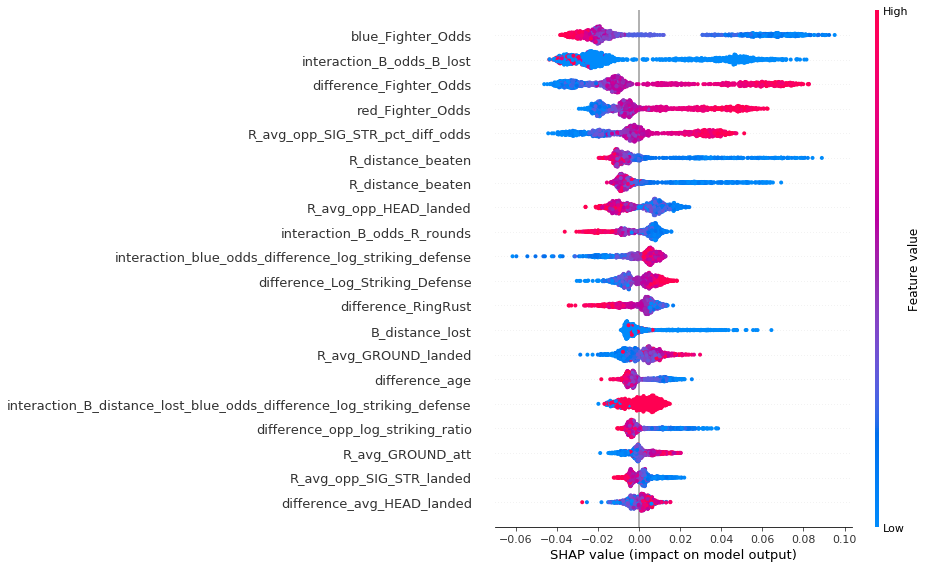

In [20]:
check(model_forest, X_train, y_train)

In [31]:
from BorutaShap import BorutaShap

model = XGBClassifier(max_depth=4)
Feature_Selector = BorutaShap(model =model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]3 attributes confirmed important: ['R_distance_beaten', 'interaction_B_odds_B_lost', 'blue_Fighter_Odds']
318 attributes confirmed unimportant: ['difference_avg_GROUND_att', 'R_avg_DISTANCE_landed', 'B_avg_LEG_landed', 'B_Weight_lbs', 'difference_avg_opp_TD_landed', 'B_avg_DISTANCE_landed', 'R_avg_opp_LEG_landed', 'B_Takedown Accuracy', 'title_bout', 'R_avg_TOTAL_STR_landed', 'difference_win_by_Submission', 'difference_opp_log_striking_ratio', 'B_elo_expected', 'wrestling_blue_skill', 'jiujitsu_blue_skill', 'R_avg_BODY_att', 'B_avg_opp_SIG_STR_att', 'R_avg_TD_att', 'interaction_blue_odds_difference_log_striking_ratio', 'B_Fight_Number', 'R_avg_opp_DISTANCE_landed', 'difference_avg_HEAD_landed', 'R_Power_Rating', 'B_Striking Accuracy', 'R_Striking Defense', 'difference_Log_Striking_Ratio', 'R_draw', 'B_avg_HEAD_att', 'B_Strikes_Absorbed_per_Minute', 'B_WinLossRatio', 'R_Strikes_Per_Minute', 'striking_red_skill', 'B_avg_opp_SIG_STR_landed'

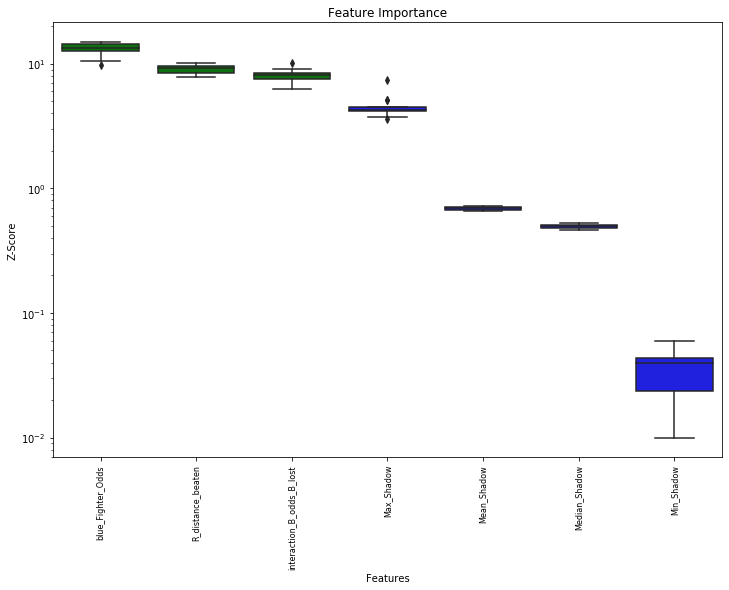

In [32]:
Feature_Selector.plot(which_features='accepted')

precision    recall  f1-score   support

           0       0.65      0.78      0.71       141
           1       0.79      0.66      0.72       175

    accuracy                           0.72       316
   macro avg       0.72      0.72      0.72       316
weighted avg       0.73      0.72      0.72       316



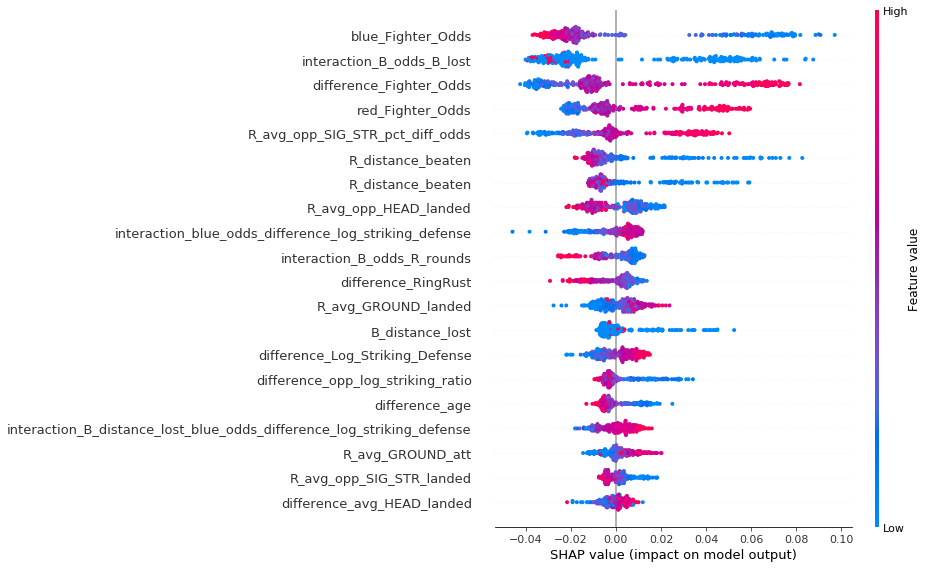

In [21]:
check(model_forest, X_test, y_test)

In [21]:
from sklearn.metrics import accuracy_score

space={'max_depth': hp.quniform("max_depth", 3, 8, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }


def hyperparameter_tuning(space):

    clf=XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

100%|██████████| 100/100 [00:09<00:00, 10.64trial/s, best loss: -0.6329113924050633]
{'colsample_bytree': 0.5430596376799169, 'gamma': 1.092460572564642, 'max_depth': 6.0, 'min_child_weight': 0.0, 'reg_alpha': 40.0, 'reg_lambda': 0.5704735822087815}


In [22]:
test = ufc.copy()
test['Elo_winner'] = np.where(test['R_elo_expected'] > test['B_elo_expected'], 1, 0)
ufc.tail()

.467926871212437, 0.13488057549379293, 1.3...   
4307  [[-0.7725445452386208, 0.8725473584245794, 0.5...   
4308  [[0.9568918001549441, 0.027558543902231163, 0....   
4309  [[1.3429529229323205, 1.121838373688357, 1.200...   

      R_Log_Striking_Defense  R_Total_Takedown_Percentage  R_elo_expected  \
4305               -0.396602                    -0.484109        0.530314   
4306               -0.733921                     0.921875        0.477730   
4307               -0.418967                    -0.837748        0.563931   
4308               -0.456815                     0.940000        0.585675   
4309               -0.611964                     0.854167        0.636867   

      log_striking_red_skill  log_striking_blue_skill  log_defense_red_skill  \
4305               26.686765                34.523327              34.845301   
4306               29.063200                22.443667              29.063200   
4307               30.733147                33.275698              29.395832   
4308               25.000000                28.458391              25.000000   
4309               31.070797                29.660582              31.070797   

      log_defense_blue_skill  R_opponents_avg_strikes_or_grapple  \
4305                0.066493                           34.845301   
4306               22.443667                            0.232934   
4307                0.036429                           29.395832   
4308               28.458391                            0.010452   
4309               29.660582                            0.023562   

      R_opp_log_striking_ratio  R_opp_log_of_striking_defense  B_Fight_Number  \
4305                  0.946429                       0.060905            12.0   
4306                  0.202630                      -0.765665            12.0   
4307                  0.937500                       0.032496            23.0   
4308                  0.379341                      -0.522554            14.0   
4309                  0.410903                      -1.190521            12.0   

      B_Stance  B_Height_cms  B_Reach_cms  B_age  B_WinLossRatio  B_RingRust  \
4305    Switch        172.72       177.80   27.0        0.818182   81.803673   
4306  Southpaw        185.42       195.58   30.0        0.636364  112.142327   
4307  Orthodox        180.34       190.50   34.0        0.636364   65.114311   
4308  Orthodox        160.02       162.56   35.0        0.461538  119.932513   
4309  Southpaw        195.58       195.58   36.0        0.545455  140.714707   

      B_Winning_Streak  B_Beaten_Similar  B_Losing_Streak  B_AVG_fight_time  \
4305               5.0                 0              0.0          9.667273   
4306               2.0                 0              0.0         12.235455   
4307               0.0                 0              2.0         11.050000   
4308               3.0                 0              0.0         12.502308   
4309               4.0                 0              0.0          6.165455   

      B_total_title_bouts  B_Takedown_Defense  B_Takedown Accuracy  \
4305             0.702646            0.535714             5.688080   
4306             0.000000            0.821577             0.405952   
4307             0.790726            0.363636             8.391682   
4308             0.000000            0.541667             0.708333   
4309             0.000000            0.735000             0.761905   

      B_distance_beaten  B_distance_lost  B_Strikes_Per_Minute  \
4305           4.145707         3.638507              0.501894   
4306           4.297855         4.471166              4.652404   
4307           5.322919         4.617590              0.455230   
4308           3.932668         2.844659              6.916503   
4309           4.718033         4.840726             10.441600   

      B_Striking Accuracy  B_Log_Striking_Ratio  \
4305             3.556826              0.000000   
4306             0.464966              1.085924   
4307  

precision    recall  f1-score   support

           0       0.63      0.80      0.71       141
           1       0.80      0.63      0.70       175

    accuracy                           0.71       316
   macro avg       0.72      0.71      0.71       316
weighted avg       0.72      0.71      0.71       316



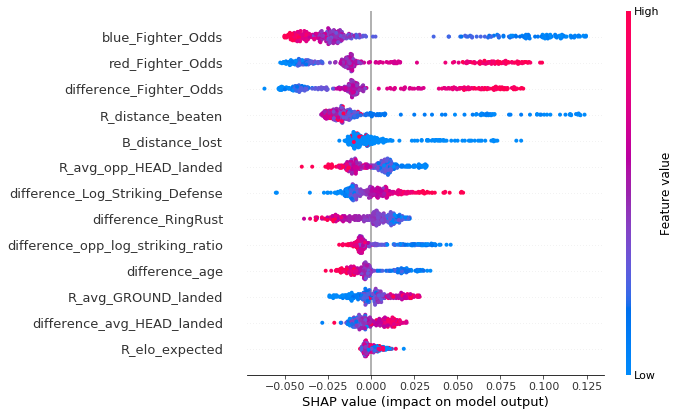

In [23]:
check(model_forest, X_test, y_test)

In [24]:
X[['difference_Fighter_Odds','difference_Log_Striking_Ratio','difference_Log_Striking_Defense',
                    'difference_age', 'difference_RingRust','striking_difference_skill','difference_fighters_elo','difference_Takedown_Defense',
                    'wrestling_difference_skill','difference_Power_Rating','g_and_p_difference_skill','jiujitsu_difference_skill','R_win_by_KO/TKO']]

KeyError: "['g_and_p_difference_skill', 'difference_Takedown_Defense', 'difference_fighters_elo', 'R_win_by_KO/TKO', 'difference_Log_Striking_Ratio', 'wrestling_difference_skill', 'jiujitsu_difference_skill', 'difference_Power_Rating', 'striking_difference_skill'] not in index"

In [90]:
data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/data.csv',sep=',')

In [93]:
data[(data.R_fighter == 'Jon Jones') | (data.B_fighter == 'Jon Jones')]

9.071429                 4.714286   
3157               4.076923              9.384615                 4.923077   
3301               3.916667              9.333333                 4.833333   
3527               4.000000              9.636364                 4.909091   
3673               3.100000              9.500000                 4.800000   
3780               3.222222             10.222222                 5.333333   
3866               3.000000             10.375000                 5.625000   
4002               8.200000              7.800000                 5.000000   
4039               3.666667             13.166667                 7.333333   
4176               4.400000             15.800000                 8.800000   
4271               5.000000             19.545455                13.090909   
4335               4.875000              7.250000                 3.250000   
4428              10.500000             38.500000                21.500000   
4520              11.000000             41.000000                15.000000   
4624                    NaN                   NaN                      NaN   

      R_avg_opp_DISTANCE_att  R_avg_opp_DISTANCE_landed  R_avg_opp_GROUND_att  \
92                 75.142857                  23.333333              0.523810   
385                70.950000                  22.400000              0.550000   
569                71.578947                  21.947368              0.578947   
643                71.111111                  22.111111              0.611111   
1313               67.222222                  26.111111              1.111111   
1931               63.375000                  19.125000              0.687500   
2529               59.533333                  18.066667              0.600000   
2890               54.142857                  17.214286              0.642857   
3157               36.538462                  10.230769              0.692308   
3301               39.166667                  11.083333              0.750000   
3527               40.181818                  11.090909              0.636364   
3673               30.500000                   8.300000              0.400000   
3780               30.000000                   7.777778              0.444444   
3866               29.375000                   7.125000              0.500000   
4002               45.800000                  14.000000             17.400000   
4039               29.166667                   7.333333              0.666667   
4176               34.000000                   8.800000              0.800000   
4271               33.454545                   9.454545              4.454545   
4335               64.000000                  24.875000              0.875000   
4428               41.000000                  13.500000              0.500000   
4520               43.000000                  19.000000              0.000000   
4624                     NaN                        NaN                   NaN   

      R_avg_opp_GROUND_landed  R_avg_opp_HEAD_att  R_avg_opp_HEAD_landed  \
92                   0.285714           63.142857              15.190476   
385                  0.300000           61.700000              15.500000   
569                  0.315789           62.842105              15.526316   
643                  0.333333           62.888889              15.722222   
1313                 0.777778           61.222222              20.666667   
1931                 0.375000           57.500000              14.062500   
2529                 0.333333           52.666667              12.333333   
2890                 0.357143           45.428571              10.785714   
3157                 0.384615           33.230769               6.769231   
3301                 0.416667           35.583333               7.333333   
3527                 0.363636           36.454545               7.272727   
3673                 0.400000           29.700000               6.400000   
3780              

In [43]:
from math import log

def split_of_from_stat(one_of_two):
    split_sentence = one_of_two.split()
    success   = int(split_sentence[0])
    attempts = int(split_sentence[-1])
    return(success,attempts)


def log_striking(row):


    if row.win_by == 'KO/TKO':
        return(row.Winner)
    

    else:
        red_significant_strikes_landed,  red_total_sig_strikes_thrown = split_of_from_stat(row['R_SIG_STR.'])
        blue_significant_strikes_landed, blue_total_sig_strikes_thrown = split_of_from_stat(row['B_SIG_STR.'])


        try:
            red_log = log(red_significant_strikes_landed/red_total_sig_strikes_thrown)

        except:
            red_log = 0


        try:
            blue_log = log(blue_significant_strikes_landed/blue_total_sig_strikes_thrown)

        except:
            blue_log = 0


        if blue_log > red_log:
            return 0
        
        elif blue_log < red_log:
            return 1

        else:
            return 0.5




data.apply(lambda x: log_striking(x), axis=1).value_counts()

1                        2188
0                        1546
0.5                        67
Anthony Johnson            11
Vitor Belfort              11
                         ... 
Ivan Menjivar               1
Olivier Aubin-Mercier       1
Sam Stout                   1
Thibault Gouti              1
Mark Weir                   1
Length: 765, dtype: int64

In [120]:




paddypower = Bookies(500)
print(paddypower.pot)
paddypower.Place_bet(10, -100, 200, 1, 1)
print(paddypower.pot)

500
520.0


array([0.56713413, 0.42246947])

In [38]:
x = ['R_fighter', 'B_fighter', 'date', 'Winner', 'title_bout', 'weight_class', 'B_current_lose_streak', 'B_current_win_streak', 'B_draw', 'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_GROUND_att', 'B_avg_GROUND_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_PASS', 'B_avg_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_TD_pct', 'B_avg_TOTAL_STR_att', 'B_avg_TOTAL_STR_landed', 'B_longest_win_streak', 'B_losses', 'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed', 'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed', 'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed', 'B_avg_opp_GROUND_att', 'B_avg_opp_GROUND_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed', 'B_avg_opp_KD', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed', 'B_avg_opp_PASS', 'B_avg_opp_REV', 'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_opp_SIG_STR_pct', 'B_avg_opp_SUB_ATT', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed', 'B_avg_opp_TD_pct', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed', 'B_total_rounds_fought', 'B_total_time_fought(seconds)', 'B_total_title_bouts', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split', 'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission', 'B_win_by_TKO_Doctor_Stoppage', 'B_wins', 'B_Stance', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs', 'R_current_lose_streak', 'R_current_win_streak', 'R_draw', 'R_avg_BODY_att', 'R_avg_BODY_landed', 'R_avg_CLINCH_att', 'R_avg_CLINCH_landed', 'R_avg_DISTANCE_att', 'R_avg_DISTANCE_landed', 'R_avg_GROUND_att', 'R_avg_GROUND_landed', 'R_avg_HEAD_att', 'R_avg_HEAD_landed', 'R_avg_KD', 'R_avg_LEG_att', 'R_avg_LEG_landed', 'R_avg_PASS', 'R_avg_REV', 'R_avg_SIG_STR_att', 'R_avg_SIG_STR_landed', 'R_avg_SIG_STR_pct', 'R_avg_SUB_ATT', 'R_avg_TD_att', 'R_avg_TD_landed', 'R_avg_TD_pct', 'R_avg_TOTAL_STR_att', 'R_avg_TOTAL_STR_landed', 'R_longest_win_streak', 'R_losses', 'R_avg_opp_BODY_att', 'R_avg_opp_BODY_landed', 'R_avg_opp_CLINCH_att', 'R_avg_opp_CLINCH_landed', 'R_avg_opp_DISTANCE_att', 'R_avg_opp_DISTANCE_landed', 'R_avg_opp_GROUND_att', 'R_avg_opp_GROUND_landed', 'R_avg_opp_HEAD_att', 'R_avg_opp_HEAD_landed', 'R_avg_opp_KD', 'R_avg_opp_LEG_att', 'R_avg_opp_LEG_landed', 'R_avg_opp_PASS', 'R_avg_opp_REV', 'R_avg_opp_SIG_STR_att', 'R_avg_opp_SIG_STR_landed', 'R_avg_opp_SIG_STR_pct', 'R_avg_opp_SUB_ATT', 'R_avg_opp_TD_att', 'R_avg_opp_TD_landed', 'R_avg_opp_TD_pct', 'R_avg_opp_TOTAL_STR_att', 'R_avg_opp_TOTAL_STR_landed', 'R_total_rounds_fought', 'R_total_time_fought(seconds)', 'R_total_title_bouts', 'R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 
'R_win_by_KO/TKO', 'R_win_by_Submission', 'R_win_by_TKO_Doctor_Stoppage', 'R_wins', 'R_Stance', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs', 'B_age', 'R_age', 'Average_Odds_f1', 'Average_Odds_f2', 'red_Fighter_Odds', 'blue_Fighter_Odds', 'win_by', 'total_fight_time', 'B_GROUND', 'R_GROUND', 'B_CLINCH', 'R_CLINCH', 'B_DISTANCE', 'R_DISTANCE', 'B_LEG', 'R_LEG', 'B_BODY', 'R_BODY', 'B_HEAD', 'R_HEAD', 'B_REV', 'R_REV', 'B_PASS', 'R_PASS', 'B_SUB_ATT', 'R_SUB_ATT', 'B_TD_pct', 'R_TD_pct', 'B_TD', 'R_TD', 'B_TOTAL_STR.', 'R_TOTAL_STR.', 'B_SIG_STR_pct', 'R_SIG_STR_pct', 'B_SIG_STR.', 'R_SIG_STR.', 'B_KD', 'R_KD', 'fighter1', 'fighter2', 'url', 'blue_fighter mean', 'blue_fighter median', 'blue_fighter std', 'red_fighter mean', 'red_fighter median', 'red_fighter std', 'over 2½ rounds mean', 'over 2½ rounds median', 'over 2½ rounds std', 'under 2½ rounds mean', 'under 2½ rounds median', 'under 2½ rounds std', 'red_fighter wins by decision mean', 'red_fighter wins by decision median', 'red_fighter wins by decision std', 'blue_fighter wins by decision mean', 'blue_fighter wins by decision median', 'blue_fighter wins by decision std', 'red_fighter wins by submission mean', 'red_fighter wins by submission median', 'red_fighter wins by submission std', 'blue_fighter wins by submission mean', 'blue_fighter wins by submission median', 'blue_fighter wins by submission std', 'red_fighter wins by tko/ko mean', 'red_fighter wins by tko/ko median', 'red_fighter wins by tko/ko std', 'blue_fighter wins by tko/ko mean', 'blue_fighter wins by tko/ko median', 'blue_fighter wins by tko/ko std', 'red_fighter wins in round 1 mean', 'red_fighter wins in round 1 median', 'red_fighter wins in round 1 std', 'red_fighter wins in round 3 mean', 'red_fighter wins in round 3 median', 'red_fighter wins in round 3 std', 'red_fighter wins in round 2 mean', 'red_fighter wins in round 2 median', 'red_fighter wins in round 2 std', 'blue_fighter wins in round 3 mean', 'blue_fighter wins in round 3 median', 'blue_fighter wins in round 3 std', 'blue_fighter wins in round 2 mean', 'blue_fighter wins in round 2 median', 'blue_fighter wins in round 2 std', 'blue_fighter wins in round 1 mean', 'blue_fighter wins in round 1 median', 'blue_fighter wins in round 1 std', 'red_stamina', 'blue_stamina', 'red_strikes_per_minute', 'blue_strikes_per_minute', 'red_striking_accuracy', 'blue_striking_accuracy', 'red_avg_takedowns', 'blue_avg_takedowns', 'red_td_accuracy', 'blue_td_accuracy', 'red_td_defense', 'blue_td_defense', 'red_strikes_absorbed_per_minute', 'blue_strikes_absorbed_per_minute', 'red_striking_defense', 'blue_striking_defense', 'red_avg_submissions', 'blue_avg_submissions', 'red_knockdowns', 'blue_knockdowns', 'red_power', 'blue_power', 'red_total_striking_ratio', 'blue_total_striking_ratio', 'red_total_takedown_percentage', 'blue_total_takedown_percentage', 'red_strikes_or_grapple', 'blue_strikes_or_grapple', 'R_Fight_Number', 'R_WinLossRatio', 'R_RingRust', 'R_AVG_fight_time', 'R_Winning_Streak', 'R_Losing_Streak', 'R_Takedown_Defense', 'R_Takedown Accuracy', 'R_Strikes_Per_Minute', 'R_Striking Accuracy', 'R_Strikes_Absorbed_per_Minute', 'R_Striking Defense', 'R_Submission Attempts', 'R_Average_Num_Takedowns', 'R_knockdows_per_minute', 'R_Power_Rating', 'R_Log_Striking_Ratio', 'R_Beaten_Names', 'R_Lost_to_names', 'R_Log_Striking_Defense', 'R_Total_Takedown_Percentage', 'R_average_strikes_or_grapple', 'R_opponents_avg_strikes_or_grapple', 'R_opp_log_striking_ratio', 'R_opp_log_of_striking_defense', 'R_odds_varience', 'B_Fight_Number', 'B_WinLossRatio', 'B_RingRust', 'B_AVG_fight_time', 'B_Winning_Streak', 'B_Losing_Streak', 'B_Takedown_Defense', 'B_Takedown Accuracy', 'B_Strikes_Per_Minute', 'B_Striking Accuracy', 'B_Strikes_Absorbed_per_Minute', 'B_Striking Defense', 'B_Submission Attempts', 'B_Average_Num_Takedowns', 'B_knockdows_per_minute', 'B_Power_Rating', 'B_Log_Striking_Ratio', 'B_Beaten_Names', 'B_Lost_to_names', 'B_Log_Striking_Defense', 'B_Total_Takedown_Percentage', 'B_average_strikes_or_grapple', 'B_opponents_avg_strikes_or_grapple', 'B_opp_log_striking_ratio', 'B_opp_log_of_striking_defense', 'B_odds_varience', 'red_fighters_elo', 'blue_fighters_elo', 'Who_Won_at_Wrestling', 'Who_Won_at_Striking', 'Who_Won_at_Ground&Pound', 'Who_Won_at_JiuJitsu', 'Who_Won_at_Grappling', 'who_won_log_striking', 'who_won_log_defense', 'red_skill', 'blue_skill', 'wrestling_red_skill', 'wrestling_blue_skill', 'striking_red_skill', 'striking_blue_skill', 'g_and_p_red_skill', 'g_and_p_blue_skill', 'jiujitsu_red_skill', 'jiujitsu_blue_skill', 'grappling_red_skill', 'grappling_blue_skill', 'log_striking_red_skill', 'log_striking_blue_skill', 'log_defense_red_skill', 'log_defense_blue_skill']

y = ['R_Log_Striking_Defense', 'B_Log_Striking_Defense', 'red_fighter median', 'blue_fighter median',
            'B_avg_opp_CLINCH_landed', 'R_avg_opp_CLINCH_landed','R_avg_GROUND_landed','B_avg_GROUND_landed',
            'wrestling_red_skill', 'wrestling_blue_skill', 'B_age','R_age']

set(y).issubset(set(x))

True

In [8]:
data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/search_trends.csv', parse_dates=['date'])
data.head()

date  Tom Aaron  Danny Abbadi  David Abbott  Shamil Abdurakhimov  \
0 2007-04-01         11            90            69                    0   
1 2007-05-01         14            52            60                    0   
2 2007-06-01         13             0            44                    0   
3 2007-07-01         11            70            48                    0   
4 2007-08-01         14           100            62                    0   

   Hiroyuki Abe  Daichi Abe  Papy Abedi  Ricardo Abreu  Klidson Abreu  \
0            81           0           0             20              0   
1            71           0           0             34              0   
2             0           0           0             18              0   
3             0           0           0             69              0   
4             0           0           0             50              0   

   Daniel Acacio  Scott Adams  Juan Adams  Anthony Adams  Israel Adesanya  \
0              0           29          18             46                0   
1              0           35          21             59                0   
2             43           32          25             25                0   
3              0           29          12             19                0   
4              0           31          13             37                0   

   Sam Adkins  Nick Agallar  Mariya Agapova  Marcelo Aguiar  Edwin Aguilar  \
0          58             0               0               9            100   
1         100             0               0              14             29   
2           0             0               0              13             30   
3           0           100               0              19             29   
4           0             0               0              23             70   

   Jessica Aguilar  Kevin Aguilar  Mike Aina  Hitomi Akano  Omari Akhmedov  \
0                8             22          0            11               0   
1               10             19          0             0               0   
2               17              0          0            13               0   
3                7             19          0             0               0   
4               15             19         29             0               0   

   Yoshihiro Akiyama  Rostem Akman  Razak Al-Hassan  Mostapha Al-Turk  \
0                  2             0                0                 0   
1                  2             0                0                 0   
2                  4             0                0                 0   
3                  2             0                0                 0   
4                  3             0                0                 0   

   Herdem Alacabek  Heili Alateng  Brett Albee  John Albert  Junior Albini  \
0                0              0            0           43              0   
1                0              0            0           37              0   
2                0              0            0           29              0   
3                0              0            0           36              0   
4                0              0            0           37              0   

   Wes Albritton  Alexandra Albu  Israel Albuquerque  Iuri Alcantara  \
0              0               0                   0               0   
1              0               0                 100               0   
2              0               8                   0               0   
3              0               0                  50               0   
4              0               0                  49               0   

   Ildemar Alcantara  Gilbert Aldana  Irene Aldana  Hector Aldana  Jose Aldo  \
0                  0              86             9              0          0   
1                  0              28             0              0          0   
2                  0              58             0             33          0   
3                  0              28             0

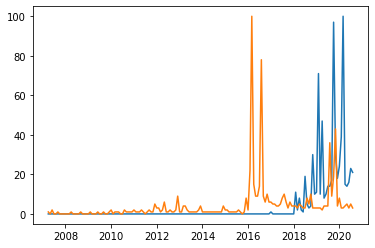

In [17]:
import matplotlib.pyplot as plt

plt.plot(data.date,data['Israel Adesanya'])
plt.plot(data.date,data['Nate Diaz'])
plt.show()